In [10]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=381, n_features=20, n_informative=15, n_redundant=5, random_state=7)

In [2]:
# define the pipeline
steps = list()
steps.append(('scaler', MinMaxScaler()))
steps.append(('model', LogisticRegression()))
pipeline = Pipeline(steps=steps)

In [3]:
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [4]:
# evaluate the model using cross-validation
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=1)

In [5]:
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

Accuracy: 85.433 (3.471)


--------------

In [427]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle

from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import beta
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import FeatureUnion
# from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import *

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [428]:
df = pd.read_pickle('../output/df_prep.pkl')

Train/Test split

In [429]:
X = df.drop(columns=['anticipatore','evento_estremo']).values
y = df['anticipatore'].values

In [430]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.1 , random_state = 1)

In [431]:
# define the pipeline
steps = list()
steps.append(('imputation',KNNImputer(n_neighbors=5,weights='distance')))
steps.append(('scaler', MinMaxScaler()))
steps.append(('model', GradientBoostingClassifier(random_state=1)))
pipeline = Pipeline(steps=steps)

In [432]:
parameters = {
    'imputation__n_neighbors':[3,5,10],
    'model__learning_rate':[0.05,0.1,0.5]
}

In [433]:
k = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

In [434]:
cv = GridSearchCV(pipeline,param_grid=parameters,cv=k,scoring='f1').fit(X_train, y_train)

In [435]:
cv.best_params_

{'imputation__n_neighbors': 3, 'model__learning_rate': 0.5}

In [436]:
cv.best_score_

0.9202711536436817

In [437]:
print("Best Estimator: \n{}\n".format(cv.best_estimator_))
print("Best Parameters: \n{}\n".format(cv.best_params_))
print("Best Test Score: \n{}\n".format(cv.best_score_))
print("Mean Test Scores: \n{}\n".format(cv.cv_results_['mean_test_score']))

Best Estimator: 
Pipeline(steps=[('imputation', KNNImputer(n_neighbors=3, weights='distance')),
                ('scaler', MinMaxScaler()),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.5,
                                            random_state=1))])

Best Parameters: 
{'imputation__n_neighbors': 3, 'model__learning_rate': 0.5}

Best Test Score: 
0.9202711536436817

Mean Test Scores: 
[0.91017029 0.91397989 0.92027115 0.90731071 0.91240257 0.91409481
 0.90196548 0.90652858 0.91453811]



In [438]:
## SIMPLY CROSS-VALIDATION
# scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv, n_jobs=1)
# scores
# print('F1: %.3f (%.3f)' % (mean(scores), std(scores)))

Check distribution shift! Two alternatives:
- adversarial validation
- histrogram check

In [439]:
def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

In [440]:
h1 = pd.DataFrame(X_train)
h2 = pd.DataFrame(X_test)

In [441]:
h1 = h1.replace('nan',np.nan)
h2 = h2.replace('nan',np.nan)
h1 = h1.fillna(0.0)
h2 = h2.fillna(0.0)
# h1 = h1.astype(float)
# h2 = h2.astype(float)

In [442]:
# h1 = h1.apply(lambda x: x / x.max())
# h2 = h2.apply(lambda x: x / x.max())

In [443]:
inters = []
for i in zip(h1,h2):
    h1[i[0]] = h1[i[0]].astype(float)
    h2[i[1]] = h2[i[1]].astype(float)
    max1 = np.max(h1[i[0]])
    max2 = np.max(h2[i[1]])
    inter = return_intersection(h1[i[0]],h2[i[1]])
    inters.append(inter)
print(np.mean(inters))

0.5121184114113889


In [444]:
# for i in zip(h1,h2):
#     plt.figure(i[0])
#     h1[i[0]].hist(density=True)
#     h2[i[1]].hist(density=True)

Let's assume train and test do not present "too much" distribution shift!

Test set

Model Test Recall: 0.8947368421052632
--------------------------------------------------
Model Test Precision: 0.9444444444444444
--------------------------------------------------
Model Test F1: 0.918918918918919
--------------------------------------------------
Model Test Accuracy: 0.918918918918919
--------------------------------------------------
Model Confusion Matrix


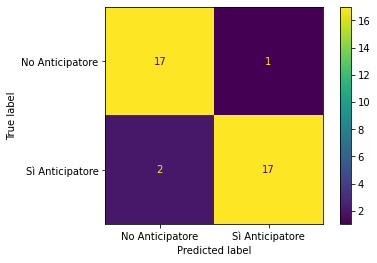

In [445]:
y_test_predict_grid = cv.predict(X_test)
print("Model Test Recall:", metrics.recall_score(y_test, y_test_predict_grid))
print('--------------------------------------------------')
print("Model Test Precision:", metrics.precision_score(y_test, y_test_predict_grid))
print('--------------------------------------------------')
print("Model Test F1:", metrics.f1_score(y_test, y_test_predict_grid))
print('--------------------------------------------------')
print("Model Test Accuracy:", metrics.accuracy_score(y_test, y_test_predict_grid))
print('--------------------------------------------------')
print('Model Confusion Matrix')
cm = confusion_matrix(y_test,y_test_predict_grid,normalize=None) # 'pred','true' altri parametri per il campo "normalize"
cmd = ConfusionMatrixDisplay(cm,display_labels=['No Anticipatore','Sì Anticipatore']).plot()

Save pipeline for future prediction

In [446]:
with open('meteo_adversity_anticipator.pkl','wb') as file:
    pickle.dump(cv, file)